This scripts test how interpolation can be done via performing Fourier and inverse Fourier transform on a padded image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter
import dxchange # this is a convenient TIFF I/O package. To install with conda, do conda install dxchange
import os
print(os.getcwd())
%matplotlib inline

/raid/home/mingdu/programs/point_projection_magnification


In [2]:
from pyfftw.interfaces.numpy_fft import fft2, ifft2, fftshift, ifftshift

In [3]:
def plot_img(a):
    plt.figure()
    plt.imshow(a)
    plt.show()

def generate_gaussian(size, sigma):
    x = np.arange(size, dtype=np.float32)
    y = np.arange(size, dtype=np.float32)
    x = x - ((size - 1) / 2.)
    y = y - ((size - 1) / 2.)
    xx, yy = np.meshgrid(x, y)
    a = 1. / (2 * np.pi * sigma ** 2) * np.exp(-(xx ** 2 + yy ** 2) / (2 * sigma ** 2))
    return a

We first test this with a band-limited image.

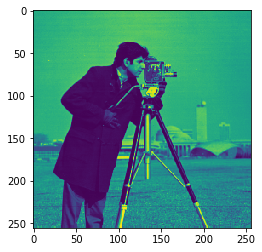

In [4]:
# load raw image
img = dxchange.read_tiff('cameraman.tif')
plot_img(img)

/raid/home/mingdu/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


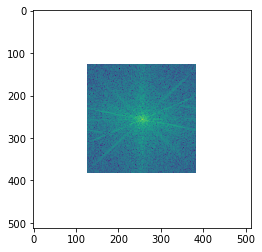

In [5]:
# pad spectrum
img_fft = fftshift(fft2(img))
img_fft = np.pad(img_fft, [[128, 128], [128, 128]], 'constant')
plot_img(np.log(np.abs(img_fft)))

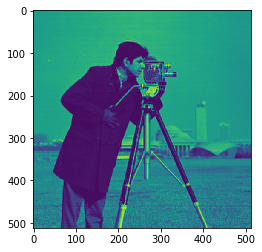

In [6]:
# inverse transform
new = np.abs(ifft2(ifftshift(img_fft)))
plot_img(new)

We will show next that while this method works well for band-limited images, it doesn't perform nicely for space-limited images whose spectra do not have a finite extent. 

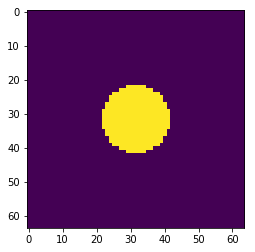

In [7]:
x = y = np.arange(64) - 31.5
xx, yy = np.meshgrid(x, y)
raw = (xx ** 2 + yy ** 2 < 10 ** 2).astype(float)
plot_img(raw)

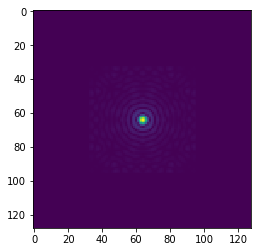

In [8]:
# pad spectrum
raw_fft = fftshift(fft2(raw))
raw_fft = np.pad(raw_fft, [[32, 32], [32, 32]], 'constant')
plot_img(np.abs(raw_fft))

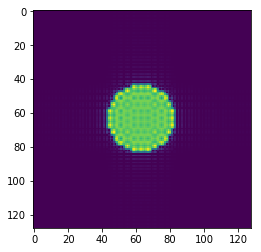

In [9]:
# inverse transform
new = np.abs(ifft2(ifftshift(raw_fft)))
plot_img(new)

For space-limited images, artifacts are produced since the spectrum has non-zero content at the edge of padding. In this case, a Gaussian mask has to be applied in Fourier domain to diminish the high frequency part of the unpadded spectrum.

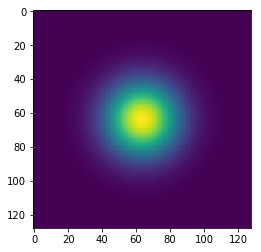

In [10]:
# create a Gaussian mask
gaussian_mask = generate_gaussian(128, 15)
plot_img(gaussian_mask)

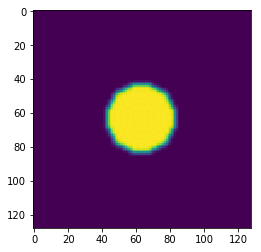

In [11]:
# apply mask and do inverse transform
gaussian_mask = gaussian_mask.astype(np.complex64)
new = np.abs(ifft2(ifftshift(raw_fft * gaussian_mask)))
plot_img(new)

Note that this treatment is equivalent to inserting zeros BETWEEN samples, and do a Gaussian filtering in real space.

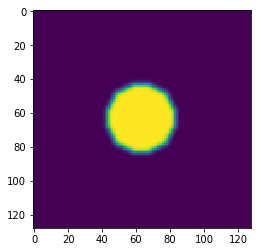

In [12]:
raw_btw = np.zeros(np.array(raw.shape) * 2)
raw_btw[::2, ::2] = raw
new = gaussian_filter(raw_btw, 1.5)
plot_img(new)

If we examine the spectrum of the zero-inserted raw image, we will find that the original spectrum is deplicated into 4 copies. The Gaussian filtering applied in real space is equivalent to a Gaussian mask that selects and vignetts only the central copy of the spectrum.

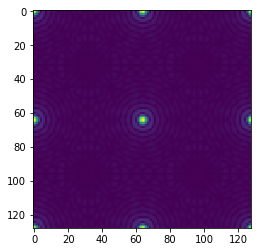

In [13]:
plot_img(np.abs(fftshift(fft2(raw_btw))))